# Notebook C: Find GSM flux bounds by constraining the GSM with <sup>13</sup>C-MFA
This Jupyter notebook focuses on using Flux Variability Analysis (FVA) to find the bounds of each reaction in a Genome Scale Model (GSM) when <sup>13</sup>C-MFA reactions are used for GSM boundries.

### Objective
The primary objective of this analysis is to use the GSM to extrapolate the rates of reactions outside the scope of 13C-MFA. We explore the genome scale metabolic flux profiles when <i>Y. lipolytica</i> consumes glucose, glycerol, acetate, and oleic acid. 

### Important Functions
- `generate_gsm_constraints_from_MFA`: Generates a straindesign constraint string of GSM constraints from MFA data
- `add_gsm_bounds_from_mfa`: This function uses an MFA reaction dictionary to generate bounds for the GSM reactions using FBA with the GSM.
- `get_gsm_df_from_constraints`: This function uses an MFA reaction dictionary to generate bounds for the MFA reactions using FBA with the GSM.
- `plot_flux_map`: This function plots flux values or flux bounds using data from columns of the central flux dataframe.

### Load imports

In [1]:
import cobra
import pandas as pd
import sys

source_dir = '../src'
sys.path.append(source_dir)

from gsm_bounds_from_mfa.generate_gsm_constraints_from_MFA import generate_gsm_constraints_from_MFA
from gsm_bounds_from_mfa.add_gsm_bounds_from_mfa import add_gsm_bounds_from_mfa
from gsm_bounds_from_mfa.get_gsm_df_from_constraints import get_gsm_df_from_constraints

from plotting.plot_flux_map import plot_flux_map

### Load the genome scale model

In [2]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_3.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [3]:
model.reactions.get_by_id('EX_glc(e)').id = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

Reaction identifier,EX_glc_e
Name,D Glucose exchange
Memory address,0x2d48a2ec0
Stoichiometry,glc_D[e] <=> D_Glucose <=>
GPR,YALI0D01111g or YALI0D18876g or YALI0D00132g or YALI0B01342g or YALI0E23287g or YALI0B00396g or...
Lower bound,-10.0
Upper bound,1000.0


### Load 13C-MFA data

In [4]:
central_rxn_df = pd.read_excel('../data/13c_mfa/Full MFA data 01192024.xlsx', sheet_name='Full MFA Data 01192024')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head()

There are 46 reactions in the 13C MFA that are mapped to the GSM


,Pathway,ID,Equation,reaction_ids,Location on map,Glucose MFA Flux,Glucose MFA LB,Glucose MFA UB,Glycerol MFA Flux,Glycerol MFA LB,Glycerol MFA UB,Oleic Acid MFA Flux,Oleic Acid MFA LB,Oleic Acid MFA UB
0,uptake,gluc uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,"(-1180, 1175)",100.0000,100.000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN
1,uptake,glyc uptake,Glycerol -> GLYC,reverse_GLYCt,"(-1376, 417)",NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN
2,uptake,R3.2,GLYC + ATP -> DHAP + 1.5*ATP,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP,OCDCEAt,"(-55, 111)",NaN,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.000
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,"(-1180, 960)",18.0175,9.792,23.5403,-41.3947,-41.5761,-36.5906,-305.8491,-319.0201,-256.517


## Glucose

### Generate MFA-based constraint string for glucose

In [5]:
mfa_reactions_to_use_glucose = [    
    # glycolysis
    'Glucose + ATP -> G6P',
    'G6P <-> F6P',
    'F6P + ATP <-> FBP',
    'FBP <-> DHAP + GAP',
    'DHAP <-> GAP',
    'GAP <-> G3P + ATP + NADH',
    'G3P <-> PEP',

    # pentose phosphate pathway
    'G6P -> PG6 + NADPH',
    'PG6 -> Ru5P + CO2 + NADPH',
    'Ru5P <-> R5P',
    'Ru5P <-> X5P',
    'X5P <-> GAP + TKC2',
    'E4P + TKC2 <-> F6P',
    'R5P + TKC2 <-> S7P',
    'GAP + TAC3 <-> F6P',
    'S7P <-> E4P + TAC3',

    # TCA cycle
    'PYRmit -> ACCOAmit + CO2 + NADH',
    'ACCOAmit + OAAmit -> CITmit',
    'CITmit <-> ICTmit',
    'ICTmit -> AKG + CO2 + NADH',
    'ICTmit -> AKG + CO2 + NADPH',
    'AKG -> 0.5*SUCmit + 0.5*SUCmit + CO2 + ATP + NADH',
    'SUCmit <-> FUMmit + 1.5*ATP',
    '0.5*FUMmit + 0.5*FUMmit <-> 0.5*MALmit + 0.5*MALmit',
    'MALmit <-> OAAmit + NADH',

    # glyoxylate shunt
    'ICTcyt -> GLYOXYcyt + SUCcyt',
    'ACCOAcyt + GLYOXYcyt -> MALcyt', # malate synthase causes problem

    # atp citrate lyase
    'CITcyt + ATP -> OAAcyt + ACCOAcyt',

    # CO2 transport
    # 'CO2 -> CO2_EX',
]

glucose_constraint_string = generate_gsm_constraints_from_MFA(mfa_reactions_to_use = mfa_reactions_to_use_glucose, central_rxn_df = central_rxn_df, substrate = 'Glucose')
glucose_constraint_string

'-EX_glc_e >= 100.0, -EX_glc_e <= 100.0, PGI >= 9.792, PGI <= 23.5403, PFK - FBP >= 53.3756, PFK - FBP <= 59.0811, FBA >= 53.3756, FBA <= 59.0811, TPI >= 51.7849, TPI <= 57.7445, GAPD >= 125.282, GAPD <= 135.6607, ENO >= 120.3684, ENO <= 131.5478, G6PDH2 >= 55.2801, G6PDH2 <= 69.7078, GND >= 55.2801, GND <= 69.7078, -RPI >= 20.775, -RPI <= 25.492, RPE >= 34.5248, RPE <= 44.223, TKT1 + TKT2 >= 34.5248, TKT1 + TKT2 <= 44.223, TKT2 >= 16.0395, TKT2 <= 20.9632, TKT1 >= 18.4561, TKT1 <= 23.2611, TALA >= 18.4561, TALA <= 23.2611, TALA >= 18.4561, TALA <= 23.2611, PDHm >= 86.6598, PDHm <= 102.7414, CSm >= 81.9247, CSm <= 98.5614, ACONTm >= 13.2107, ACONTm <= 53.4877, ICDHxm >= 0.0, ICDHxm <= 18.0326, ICDHym >= 0.0, ICDHym <= 33.3765, -SUCOASm >= 0.3408, -SUCOASm <= 42.8441, SUCD2_u6m + SUCD1m >= 20.6873, SUCD2_u6m + SUCD1m <= 49.1634, FUMm >= 23.0833, FUMm <= 51.1684, MDHm >= 90.7308, MDHm <= 112.1369, ICL >= 5.3272, ICL <= 21.8437, MALS >= 5.3272, MALS <= 21.8437, ATPCitL >= 32.966, ATPCitL 

### Add GSM bounds from MFA for glucose

In [6]:
central_rxn_df = add_gsm_bounds_from_mfa(model=model, central_rxn_df=central_rxn_df, substrate='Glucose', constraints=glucose_constraint_string)
central_rxn_df

,Pathway,ID,Equation,reaction_ids,Location on map,Glucose MFA Flux,Glucose MFA LB,Glucose MFA UB,Glycerol MFA Flux,Glycerol MFA LB,Glycerol MFA UB,Oleic Acid MFA Flux,Oleic Acid MFA LB,Oleic Acid MFA UB,Glucose MFA-Constrained GSM LB,Glucose MFA-Constrained GSM UB
0,uptake,gluc uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,"(-1180, 1175)",100.000000,100.0000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0
1,uptake,glyc uptake,Glycerol -> GLYC,reverse_GLYCt,"(-1376, 417)",NaN,NaN,NaN,1.000000e+02,100.0000,100.0000,NaN,NaN,NaN,-6.2735,-0.0
2,uptake,R3.2,GLYC + ATP -> DHAP + 1.5*ATP,NaN,NaN,NaN,NaN,NaN,1.000000e+02,100.0000,100.0000,NaN,NaN,NaN,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP,OCDCEAt,"(-55, 111)",NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+02,100.0000,100.0000,0.0,-0.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,"(-1180, 960)",18.017500,9.7920,23.5403,-4.139470e+01,-41.5761,-36.5906,-3.058491e+02,-319.0201,-256.5170,21.59084,23.5403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,biomass formation,R80 gluc 1207 avg AA 10%lip,0.355*ALA + 0.13*ARG + 0.1725*ASN + 0.1725*ASP...,biomass_glucose or biomass_oil,NaN,12.075900,10.6005,12.7776,5.189700e+00,5.1208,5.1897,3.333290e+01,31.7890,33.3229,10.6005,12.498455
68,energy metabolism,R81,ATP -> ATP_maintenance,ATPM,NaN,777.930800,616.6971,1065.5000,7.326892e+02,728.5648,746.4218,4.958800e+03,4913.0000,5235.4000,0.0,218.874647
69,energy metabolism,R82,NADH -> NADPH,NaN,NaN,0.000002,0.0000,20.6486,1.000000e-07,0.0000,9.5711,9.987400e-08,0.0000,104.9593,,
70,energy metabolism,R83,NADH -> 2.5*ATP,NaN,"(-1670, -1155)",308.147900,264.7777,398.4924,2.042585e+02,202.6647,208.1858,1.520900e+03,1503.1000,1612.3000,,


### Generate GSM bounds from 13C-MFA for Glucose

In [7]:
glucose_gsm_df_from_constraints = get_gsm_df_from_constraints(
    model=model, 
    substrate='Glucose',
    constraints=glucose_constraint_string,
)

# save the dataframe to a csv file
glucose_gsm_df_from_constraints.to_csv('../results/gsm_fluxes/glucose_mfa_bound_gsm_fluxes.csv', index=False)

glucose_gsm_df_from_constraints.head(10)

,reaction_id,reaction_name,full_reaction,Glucose MFA-Constrained GSM flux,Glucose MFA-Constrained GSM LB,Glucose MFA-Constrained GSM UB
0,13BGH,Endo 1 3 beta glucan glucohydrase,13BDglcn[c] + h2o[c] --> glc_D[c],0.000000,0.000000,109.437324
1,13BGHe,Exo 1 3 beta glucan glucohydrase,13BDglcn[e] + h2o[e] --> glc_D[e],0.000000,0.000000,-0.000000
2,ASADi,aspartate semialdehyde dehydrogenase irreversible,4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...,4.215823,3.575628,47.544022
3,2DDA7Ptm,2 Dehydro 3 deoxy D arabino heptonate7 phohsph...,2dda7p[c] <=> 2dda7p[m],-1.538261,-4.165460,-0.000000
4,2DHPtm,2 Dehydropantoate mitochondrial transport,2dhp[c] <=> 2dhp[m],0.000000,0.000000,6.269987
5,2OHPH_5tn,2 Octaprenyl 6 hydroxyphenol nuclear transport,2ohph_5[c] <=> 2ohph_5[n],0.000000,0.000000,-0.000000
6,2OMPH_5tm,2 Octaprenyl 6 methoxyprenol mitochondrial tra...,2omph_5[c] <=> 2omph_5[m],0.000000,0.000000,-0.000000
7,2OMPH_5tn,2 Octaprenyl 6 methoxyprenol nuclear transport,2omph_5[c] <=> 2omph_5[n],0.000000,0.000000,-0.000000
8,ASPKi,aspartate kinase irreversible,asp_L[c] + atp[c] --> 4pasp[c] + adp[c],4.215823,3.575628,47.544022
9,34HPPOR,4 Hydroxyphenylpyruvateoxygen oxidoreductase,34hpp[c] + o2[c] --> co2[c] + hgentis[c],0.000000,0.000000,2.651833


### Plot flux map with bounds from 13C-MFA

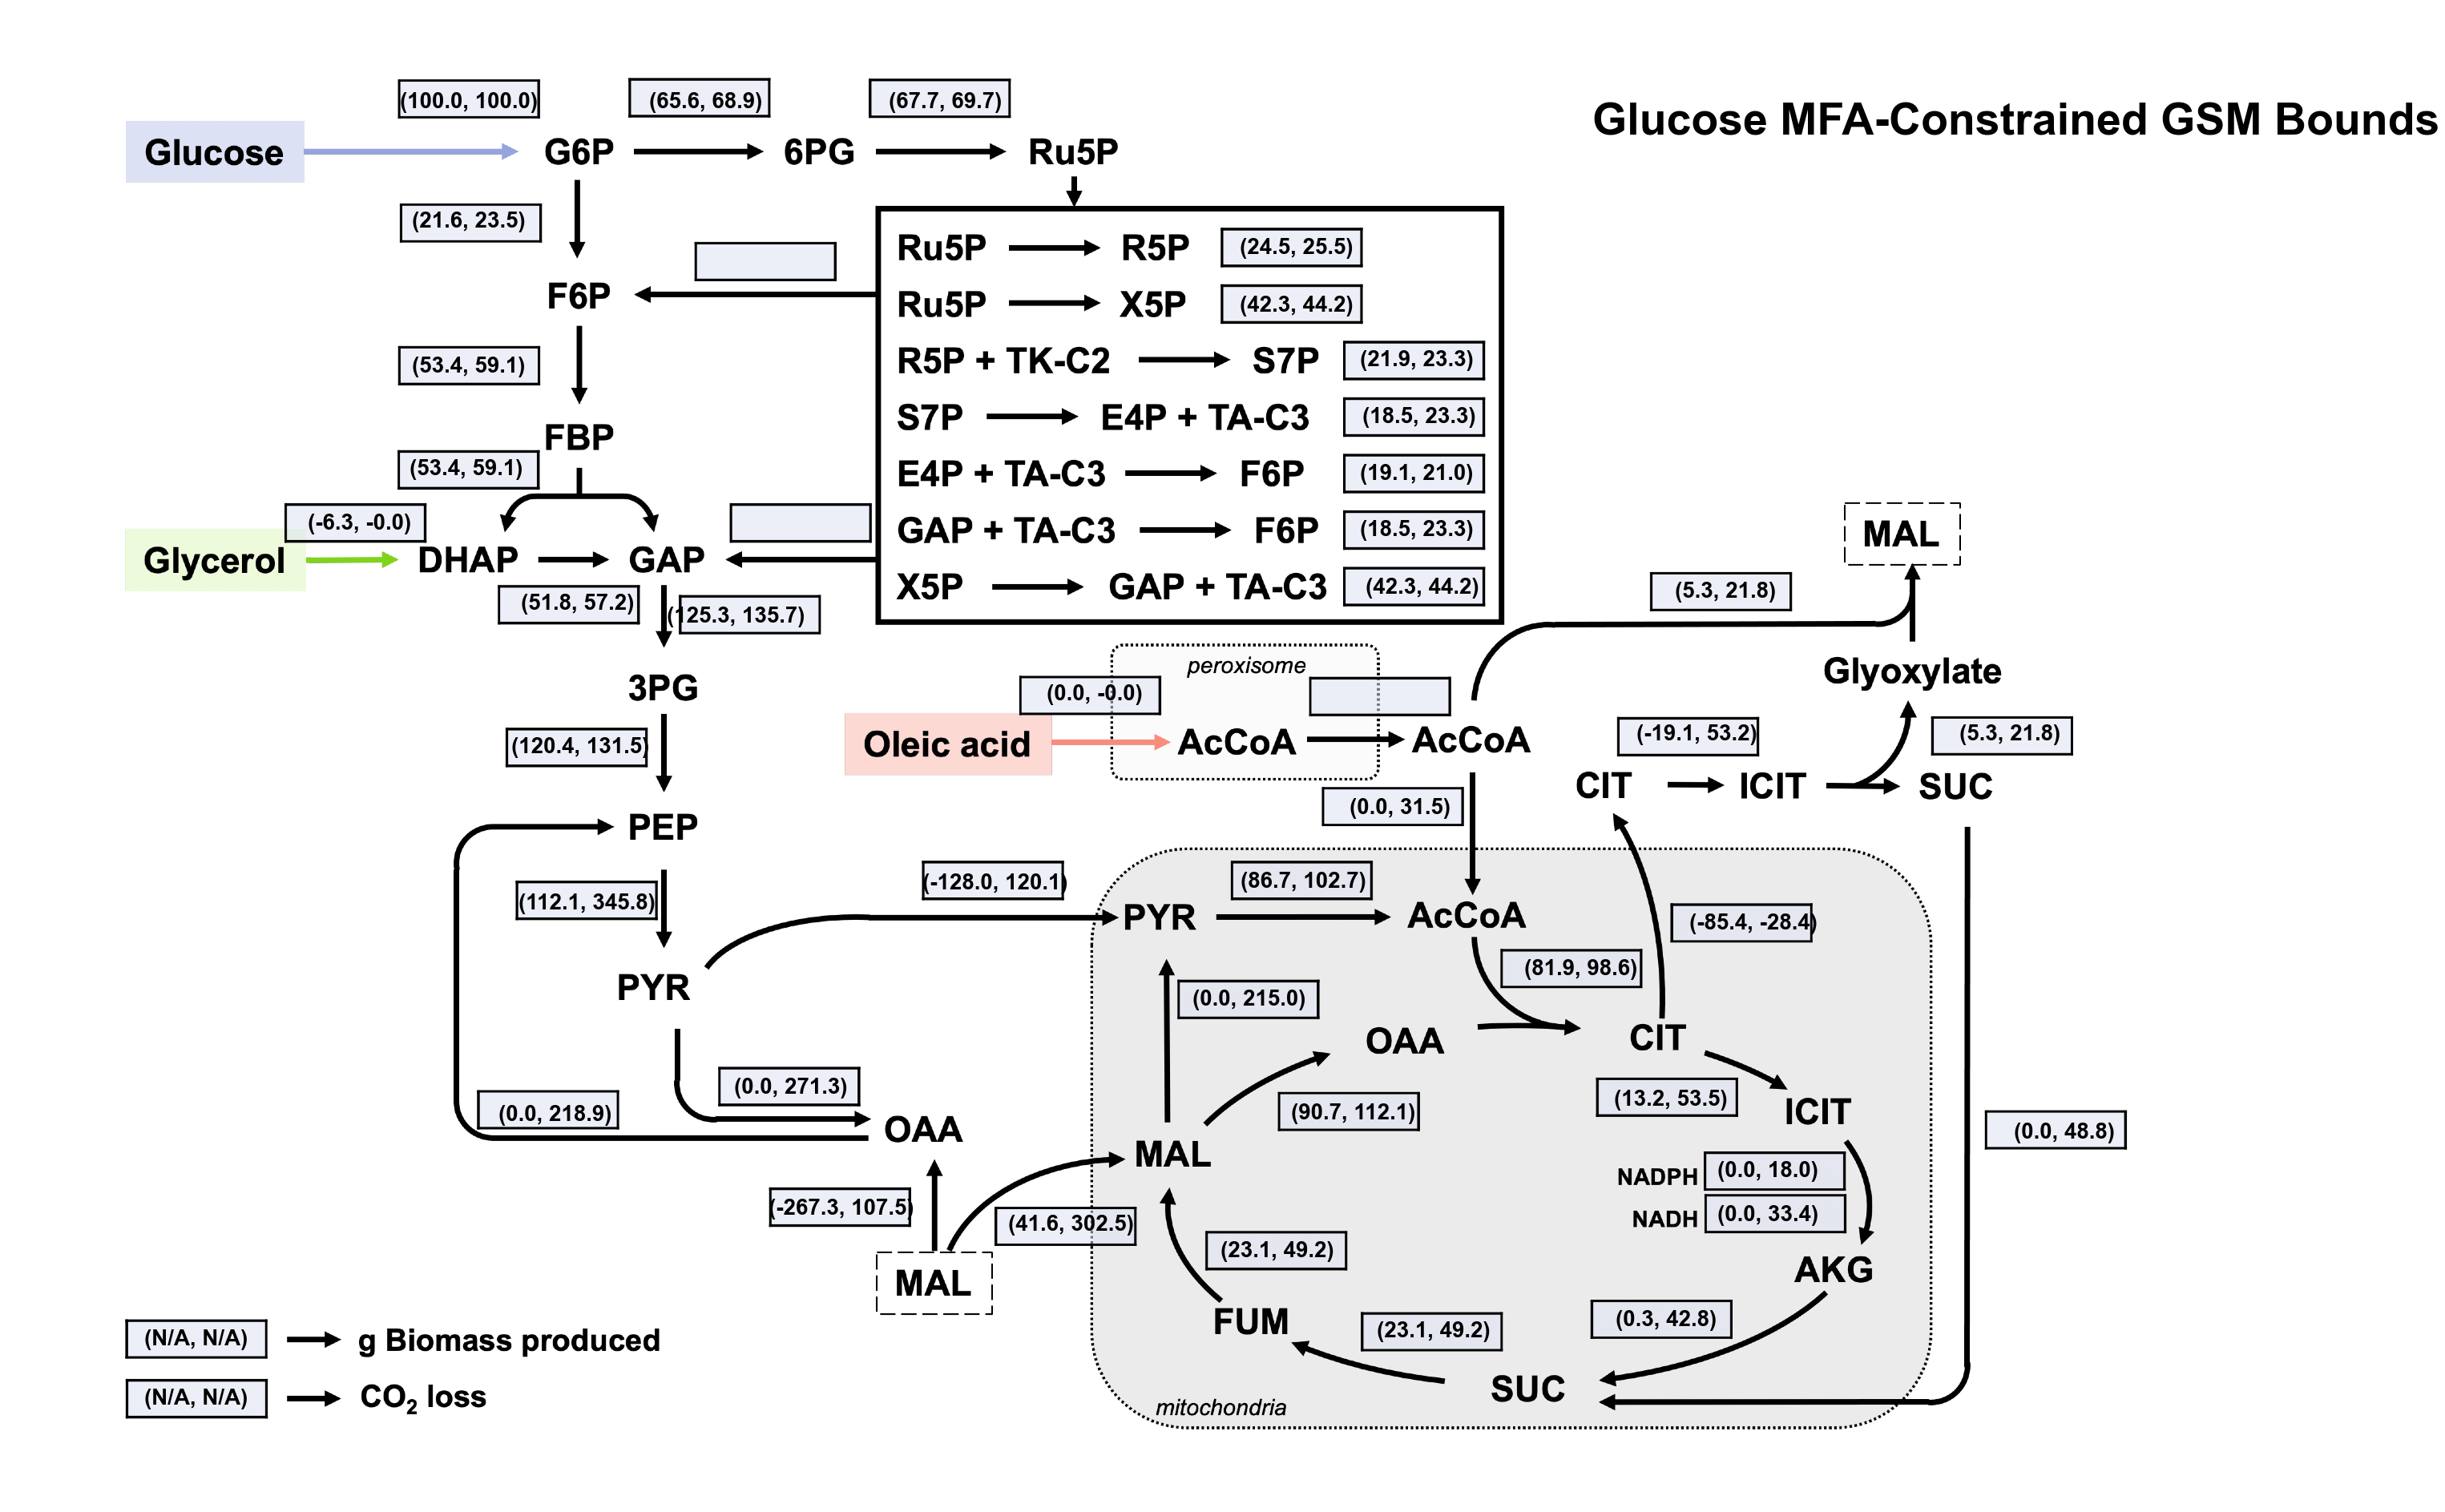

In [8]:
glucose_mfa_map = plot_flux_map(
    flux_df=central_rxn_df, 
    flux_column=['Glucose MFA-Constrained GSM LB', 'Glucose MFA-Constrained GSM UB'],
    title_string='Glucose MFA-Constrained GSM Bounds',
    file_name='../figures/Glucose MFA-Constrained GSM Bounds.png',
)

## Glycerol

### Generate MFA-based constraint string for glycerol

In [9]:
mfa_reactions_to_use_glycerol = [    
    # glycolysis
    'Glycerol -> GLYC',
    # 'G6P <-> F6P',
    # 'F6P + ATP <-> FBP',
    # 'FBP <-> DHAP + GAP',
    'DHAP <-> GAP',
    # 'GAP <-> G3P + ATP + NADH',
    # 'G3P <-> PEP',

    # pentose phosphate pathway
    'G6P -> PG6 + NADPH',
    # 'PG6 -> Ru5P + CO2 + NADPH',
    # 'Ru5P <-> R5P',
    # 'Ru5P <-> X5P',
    # 'X5P <-> GAP + TKC2',
    # 'E4P + TKC2 <-> F6P',
    # 'R5P + TKC2 <-> S7P',
    # 'GAP + TAC3 <-> F6P',
    # 'S7P <-> E4P + TAC3',

    # TCA cycle
    # 'PYRmit -> ACCOAmit + CO2 + NADH',
    # 'ACCOAmit + OAAmit -> CITmit',
    # 'CITmit <-> ICTmit',
    # 'ICTmit -> AKG + CO2 + NADH',
    # 'ICTmit -> AKG + CO2 + NADPH',
    # 'AKG -> 0.5*SUCmit + 0.5*SUCmit + CO2 + ATP + NADH',
    # 'SUCmit <-> FUMmit + 1.5*ATP',
    # '0.5*FUMmit + 0.5*FUMmit <-> 0.5*MALmit + 0.5*MALmit',
    # 'MALmit <-> OAAmit + NADH',

    # glyoxylate shunt
    # 'ICTcyt -> GLYOXYcyt + SUCcyt',
    # 'ACCOAcyt + GLYOXYcyt -> MALcyt', # malate synthase causes problem

    # atp citrate lyase
    # 'CITcyt + ATP -> OAAcyt + ACCOAcyt',

    # CO2 transport
    # 'CO2 -> CO2_EX',
]

glycerol_constraint_string = generate_gsm_constraints_from_MFA(mfa_reactions_to_use = mfa_reactions_to_use_glycerol, central_rxn_df = central_rxn_df, substrate = 'Glycerol')
glycerol_constraint_string

'-GLYCt >= 100.0, -GLYCt <= 100.0, TPI >= 78.6429, TPI <= 80.3046, G6PDH2 >= 27.7687, G6PDH2 <= 32.7664, biomass_glucose >= 5.1208, biomass_glucose <= 5.1897, biomass_oil = 0, biomass_C = 0, biomass_N = 0'

### Add GSM bounds from MFA for glycerol

In [10]:
central_rxn_df = add_gsm_bounds_from_mfa(model=model, central_rxn_df=central_rxn_df, substrate='Glycerol', constraints=glycerol_constraint_string)

central_rxn_df.head(10)

,Pathway,ID,Equation,reaction_ids,Location on map,Glucose MFA Flux,Glucose MFA LB,Glucose MFA UB,Glycerol MFA Flux,Glycerol MFA LB,Glycerol MFA UB,Oleic Acid MFA Flux,Oleic Acid MFA LB,Oleic Acid MFA UB,Glucose MFA-Constrained GSM LB,Glucose MFA-Constrained GSM UB,Glycerol MFA-Constrained GSM LB,Glycerol MFA-Constrained GSM UB
0,uptake,gluc uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,"(-1180, 1175)",100.0000,100.0000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,0.0,-0.0
1,uptake,glyc uptake,Glycerol -> GLYC,reverse_GLYCt,"(-1376, 417)",NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN,-6.2735,-0.0,100.0,100.0
2,uptake,R3.2,GLYC + ATP -> DHAP + 1.5*ATP,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP,OCDCEAt,"(-55, 111)",NaN,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.0000,0.0,-0.0,0.0,-0.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,"(-1180, 960)",18.0175,9.7920,23.5403,-41.3947,-41.5761,-36.5906,-305.8491,-319.0201,-256.5170,21.59084,23.5403,-36.776517,-31.998287
5,glycolysis/gluconeogensis,R5 net,F6P + ATP <-> FBP,PFK or reverse_FBP,"(-1180, 700)",56.7218,53.3756,59.0811,-20.6531,-20.7135,-19.0518,-144.5891,-148.9667,-128.1481,53.3756,59.0811,-24.99009,-19.152749
6,glycolysis/gluconeogensis,R6 net,FBP <-> DHAP + GAP,FBA,"(-1184, 515)",56.7218,53.3756,59.0811,-20.6531,-20.7135,-19.0518,-144.5891,-148.9667,-128.1481,53.3756,59.0811,-24.99009,-19.152749
7,glycolysis/gluconeogensis,R7 net,DHAP <-> GAP,TPI,"(-984, 273)",55.2244,51.7849,57.7445,78.7033,78.6429,80.3046,-152.8556,-157.2308,-136.4145,51.7849,57.178615,79.605612,80.3046
8,glycolysis/gluconeogensis,R8 net,GAP <-> G3P + ATP + NADH,GAPD,"(-700, 250)",130.1644,125.2820,135.6607,67.9337,67.8732,69.5346,-218.6947,-223.0502,-202.2536,125.282,135.6607,70.295388,71.14059
9,glycolysis/gluconeogensis,R9 net,G3P <-> PEP,ENO,"(-980, 15)",125.4818,120.3684,131.5478,66.3897,66.3727,67.9837,-224.0012,-224.3677,-206.2233,120.3684,131.5478,39.367417,43.451415


### Generate GSM bounds from 13C-MFA for Glycerol

In [11]:
glycerol_gsm_df_from_constraints = get_gsm_df_from_constraints(
    model=model, 
    substrate='Glycerol',
    constraints=glycerol_constraint_string,
)

# save the dataframe to a csv file
glycerol_gsm_df_from_constraints.to_csv('../results/gsm_fluxes/glycerol_mfa_bound_gsm_fluxes.csv', index=False)

glycerol_gsm_df_from_constraints.head(10)

,reaction_id,reaction_name,full_reaction,Glycerol MFA-Constrained GSM flux,Glycerol MFA-Constrained GSM LB,Glycerol MFA-Constrained GSM UB
0,13BGH,Endo 1 3 beta glucan glucohydrase,13BDglcn[c] + h2o[c] --> glc_D[c],0.000000,0.000000,2.917142
1,13BGHe,Exo 1 3 beta glucan glucohydrase,13BDglcn[e] + h2o[e] --> glc_D[e],0.000000,0.000000,-0.000000
2,ASADi,aspartate semialdehyde dehydrogenase irreversible,4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...,4.503118,2.622592,5.614604
3,2DDA7Ptm,2 Dehydro 3 deoxy D arabino heptonate7 phohsph...,2dda7p[c] <=> 2dda7p[m],0.000000,-1.160637,-0.000000
4,2DHPtm,2 Dehydropantoate mitochondrial transport,2dhp[c] <=> 2dhp[m],0.000000,0.000000,0.105479
5,2OHPH_5tn,2 Octaprenyl 6 hydroxyphenol nuclear transport,2ohph_5[c] <=> 2ohph_5[n],0.000000,0.000000,-0.000000
6,2OMPH_5tm,2 Octaprenyl 6 methoxyprenol mitochondrial tra...,2omph_5[c] <=> 2omph_5[m],0.000000,0.000000,-0.000000
7,2OMPH_5tn,2 Octaprenyl 6 methoxyprenol nuclear transport,2omph_5[c] <=> 2omph_5[n],0.000000,0.000000,-0.000000
8,ASPKi,aspartate kinase irreversible,asp_L[c] + atp[c] --> 4pasp[c] + adp[c],4.503118,2.622592,5.614604
9,34HPPOR,4 Hydroxyphenylpyruvateoxygen oxidoreductase,34hpp[c] + o2[c] --> co2[c] + hgentis[c],0.000000,0.000000,0.530389


### Plot flux map with bounds from 13C-MFA

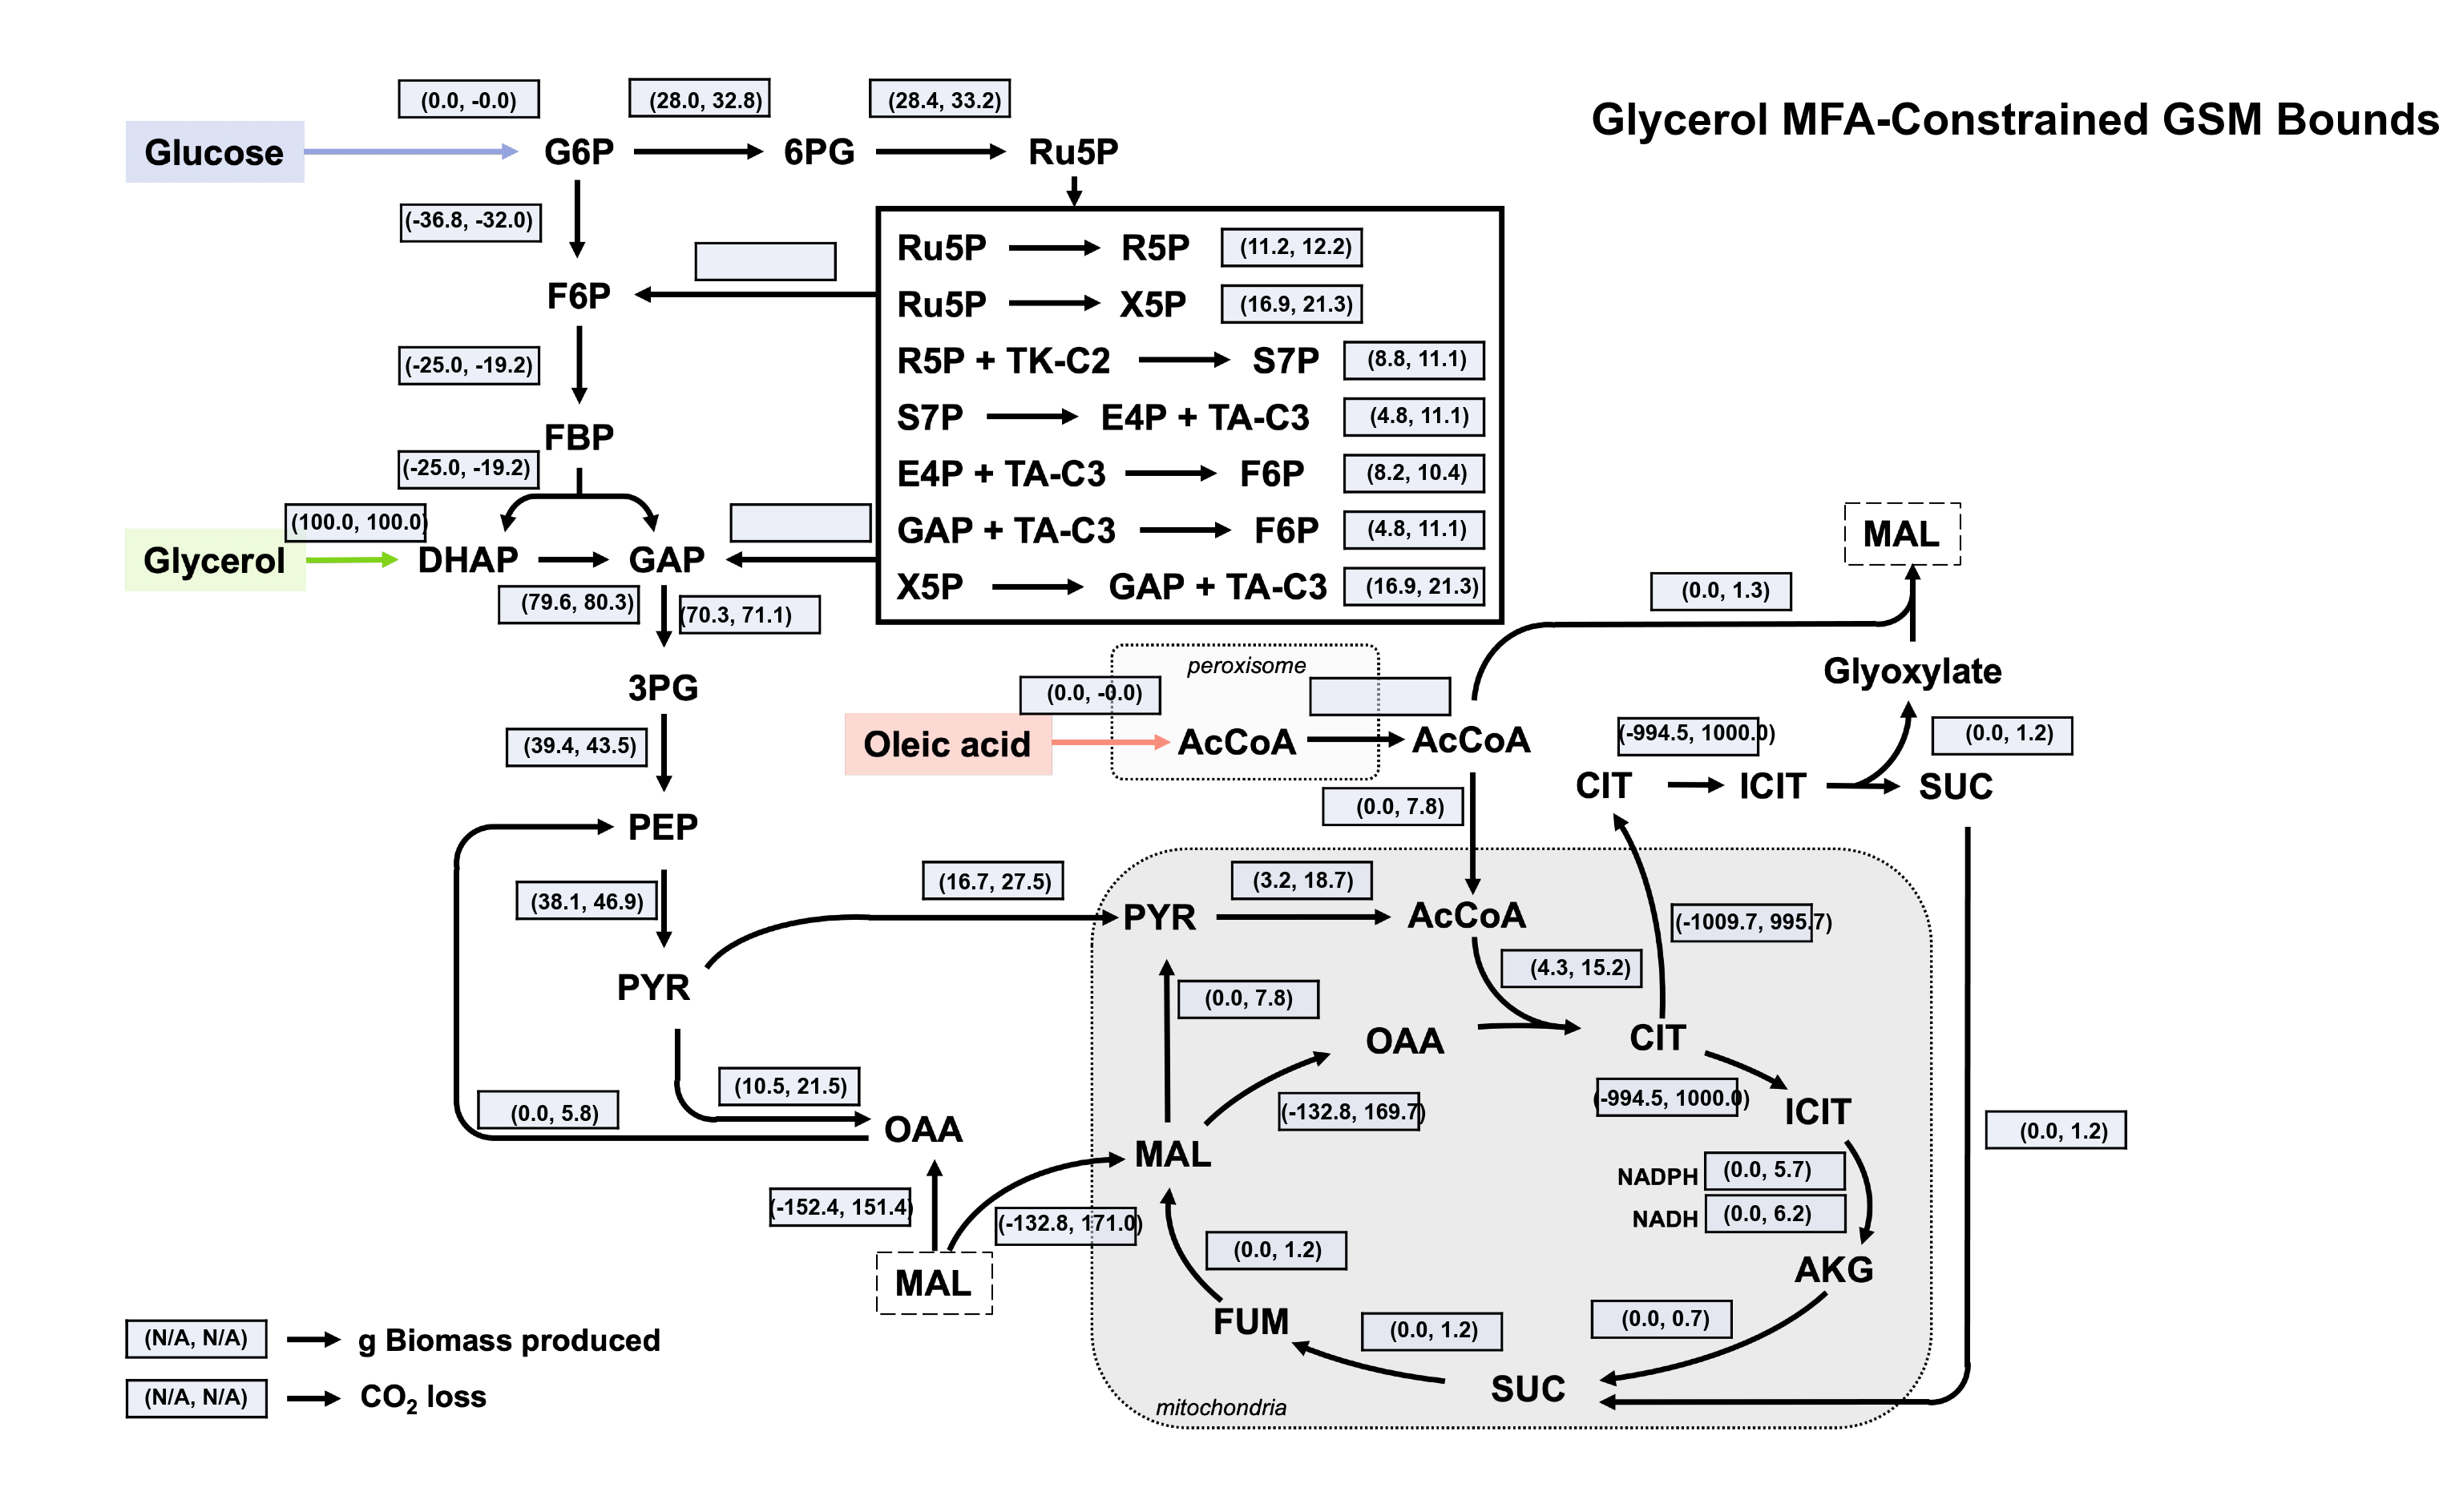

In [12]:
glycerol_mfa_map = plot_flux_map(
    flux_df=central_rxn_df, 
    flux_column=['Glycerol MFA-Constrained GSM LB', 'Glycerol MFA-Constrained GSM UB'],
    title_string='Glycerol MFA-Constrained GSM Bounds',
    file_name='../figures/Glycerol MFA-Constrained GSM Bounds.png',
)

## Oleic acid

### Generate MFA-based constraint string for oleic acid

In [13]:
mfa_reactions_to_use_oleic_acid = [    
    # uptake reaction
    'OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP',

    # glycolysis
    'G6P <-> F6P',
    'F6P + ATP <-> FBP',
    'FBP <-> DHAP + GAP',
    'DHAP <-> GAP',
    # 'GAP <-> G3P + ATP + NADH', # causes problem
    # 'G3P <-> PEP', # causes problem

    # pentose phosphate pathway
    'G6P -> PG6 + NADPH',
    'PG6 -> Ru5P + CO2 + NADPH',
    'Ru5P <-> R5P',
    'Ru5P <-> X5P',
    'X5P <-> GAP + TKC2',
    'E4P + TKC2 <-> F6P',
    'R5P + TKC2 <-> S7P',
    'GAP + TAC3 <-> F6P',
    'S7P <-> E4P + TAC3',

    # TCA cycle
    # 'PYRmit -> ACCOAmit + CO2 + NADH', # causes problem
    'ACCOAmit + OAAmit -> CITmit',
    'CITmit <-> ICTmit',
    'ICTmit -> AKG + CO2 + NADH',
    'ICTmit -> AKG + CO2 + NADPH',
    'AKG -> 0.5*SUCmit + 0.5*SUCmit + CO2 + ATP + NADH',
    'SUCmit <-> FUMmit + 1.5*ATP',
    '0.5*FUMmit + 0.5*FUMmit <-> 0.5*MALmit + 0.5*MALmit',
    'MALmit <-> OAAmit + NADH',

    # glyoxylate shunt
    'ICTcyt -> GLYOXYcyt + SUCcyt',
    'ACCOAcyt + GLYOXYcyt -> MALcyt', 

    # atp citrate lyase
    # 'CITcyt + ATP -> OAAcyt + ACCOAcyt', # causes problem

    # CO2 transport
    # 'CO2 -> CO2_EX', # causes problem
]

oleic_acid_constraint_string = generate_gsm_constraints_from_MFA(mfa_reactions_to_use = mfa_reactions_to_use_oleic_acid, central_rxn_df = central_rxn_df, substrate = 'Oleic Acid')
oleic_acid_constraint_string

'OCDCEAt >= 10.0, OCDCEAt <= 10.0, PGI >= -31.90201, PGI <= -25.651699999999998, PFK - FBP >= -14.89667, PFK - FBP <= -12.81481, FBA >= -14.89667, FBA <= -12.81481, TPI >= -15.72308, TPI <= -13.64145, G6PDH2 >= 19.98452, G6PDH2 <= 26.237119999999997, GND >= 19.98452, GND <= 26.237119999999997, -RPI >= 7.147920000000001, -RPI <= 9.23178, RPE >= 12.8368, RPE <= 17.00534, TKT1 + TKT2 >= 12.8368, TKT1 + TKT2 <= 17.00534, TKT2 >= 6.22361, TKT2 <= 8.3074, TKT1 >= 6.61369, TKT1 <= 8.69794, TALA >= 6.61369, TALA <= 8.69794, TALA >= 6.61369, TALA <= 8.69794, CSm >= 41.925599999999996, CSm <= 44.216480000000004, ACONTm >= 1.89638, ACONTm <= 7.52743, ICDHxm >= 0.0, ICDHxm <= 7.527089999999999, ICDHym >= 0.0, ICDHym <= 6.888599999999999, -SUCOASm >= 0.0, -SUCOASm <= 5.58544, SUCD2_u6m + SUCD1m >= 39.9543, SUCD2_u6m + SUCD1m <= 42.33663, FUMm >= 40.35453, FUMm <= 42.71788, MDHm >= 42.46343, MDHm <= 47.5596, ICL >= 35.4773, ICL <= 42.18486, MALS >= 35.4773, MALS <= 42.18486, biomass_oil >= 3.1789, b

### Add GSM bounds from MFA for oleic acid

In [14]:
central_rxn_df = add_gsm_bounds_from_mfa(model=model, central_rxn_df=central_rxn_df, substrate='Oleic Acid', constraints=oleic_acid_constraint_string)
central_rxn_df

,Pathway,ID,Equation,reaction_ids,Location on map,Glucose MFA Flux,Glucose MFA LB,Glucose MFA UB,Glycerol MFA Flux,Glycerol MFA LB,Glycerol MFA UB,Oleic Acid MFA Flux,Oleic Acid MFA LB,Oleic Acid MFA UB,Glucose MFA-Constrained GSM LB,Glucose MFA-Constrained GSM UB,Glycerol MFA-Constrained GSM LB,Glycerol MFA-Constrained GSM UB,Oleic Acid MFA-Constrained GSM LB,Oleic Acid MFA-Constrained GSM UB
0,uptake,gluc uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,"(-1180, 1175)",100.000000,100.0000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,0.0,-0.0,0.0,-0.0
1,uptake,glyc uptake,Glycerol -> GLYC,reverse_GLYCt,"(-1376, 417)",NaN,NaN,NaN,1.000000e+02,100.0000,100.0000,NaN,NaN,NaN,-6.2735,-0.0,100.0,100.0,-0.063537,-0.0
2,uptake,R3.2,GLYC + ATP -> DHAP + 1.5*ATP,NaN,NaN,NaN,NaN,NaN,1.000000e+02,100.0000,100.0000,NaN,NaN,NaN,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP,OCDCEAt,"(-55, 111)",NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+02,100.0000,100.0000,0.0,-0.0,0.0,-0.0,100.0,100.0
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,"(-1180, 960)",18.017500,9.7920,23.5403,-4.139470e+01,-41.5761,-36.5906,-3.058491e+02,-319.0201,-256.5170,21.59084,23.5403,-36.776517,-31.998287,-257.125896,-256.517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,biomass formation,R80 gluc 1207 avg AA 10%lip,0.355*ALA + 0.13*ARG + 0.1725*ASN + 0.1725*ASP...,biomass_glucose or biomass_oil,NaN,12.075900,10.6005,12.7776,5.189700e+00,5.1208,5.1897,3.333290e+01,31.7890,33.3229,10.6005,12.498455,5.1208,5.149818,31.789,31.795453
68,energy metabolism,R81,ATP -> ATP_maintenance,ATPM,NaN,777.930800,616.6971,1065.5000,7.326892e+02,728.5648,746.4218,4.958800e+03,4913.0000,5235.4000,0.0,218.874647,0.0,5.834283,0.0,0.913344
69,energy metabolism,R82,NADH -> NADPH,NaN,NaN,0.000002,0.0000,20.6486,1.000000e-07,0.0000,9.5711,9.987400e-08,0.0000,104.9593,,,,,,
70,energy metabolism,R83,NADH -> 2.5*ATP,NaN,"(-1670, -1155)",308.147900,264.7777,398.4924,2.042585e+02,202.6647,208.1858,1.520900e+03,1503.1000,1612.3000,,,,,,


### Generate GSM bounds from 13C-MFA for oleic acid

In [15]:
oleic_acid_gsm_df_from_constraints = get_gsm_df_from_constraints(
    model=model, 
    substrate='Oleic Acid',
    constraints=oleic_acid_constraint_string,
)

# save the dataframe to a csv file
oleic_acid_gsm_df_from_constraints.to_csv('../results/gsm_fluxes/oleic_acid_mfa_bound_gsm_fluxes.csv', index=False)

oleic_acid_gsm_df_from_constraints.head(10)

,reaction_id,reaction_name,full_reaction,Oleic Acid MFA-Constrained GSM flux,Oleic Acid MFA-Constrained GSM LB,Oleic Acid MFA-Constrained GSM UB
0,13BGH,Endo 1 3 beta glucan glucohydrase,13BDglcn[c] + h2o[c] --> glc_D[c],0.000000,0.000000,0.456672
1,13BGHe,Exo 1 3 beta glucan glucohydrase,13BDglcn[e] + h2o[e] --> glc_D[e],0.000000,0.000000,-0.000000
2,ASADi,aspartate semialdehyde dehydrogenase irreversible,4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...,6.251885,6.250616,6.598557
3,2DDA7Ptm,2 Dehydro 3 deoxy D arabino heptonate7 phohsph...,2dda7p[c] <=> 2dda7p[m],0.000000,-2.342634,-0.000000
4,2DHPtm,2 Dehydropantoate mitochondrial transport,2dhp[c] <=> 2dhp[m],0.000000,0.000000,0.027469
5,2OHPH_5tn,2 Octaprenyl 6 hydroxyphenol nuclear transport,2ohph_5[c] <=> 2ohph_5[n],0.000000,0.000000,-0.000000
6,2OMPH_5tm,2 Octaprenyl 6 methoxyprenol mitochondrial tra...,2omph_5[c] <=> 2omph_5[m],0.000000,0.000000,-0.000000
7,2OMPH_5tn,2 Octaprenyl 6 methoxyprenol nuclear transport,2omph_5[c] <=> 2omph_5[n],0.000000,0.000000,-0.000000
8,ASPKi,aspartate kinase irreversible,asp_L[c] + atp[c] --> 4pasp[c] + adp[c],6.251885,6.250616,6.598557
9,34HPPOR,4 Hydroxyphenylpyruvateoxygen oxidoreductase,34hpp[c] + o2[c] --> co2[c] + hgentis[c],0.000000,0.000000,0.061922


### Plot flux map with bounds from 13C-MFA

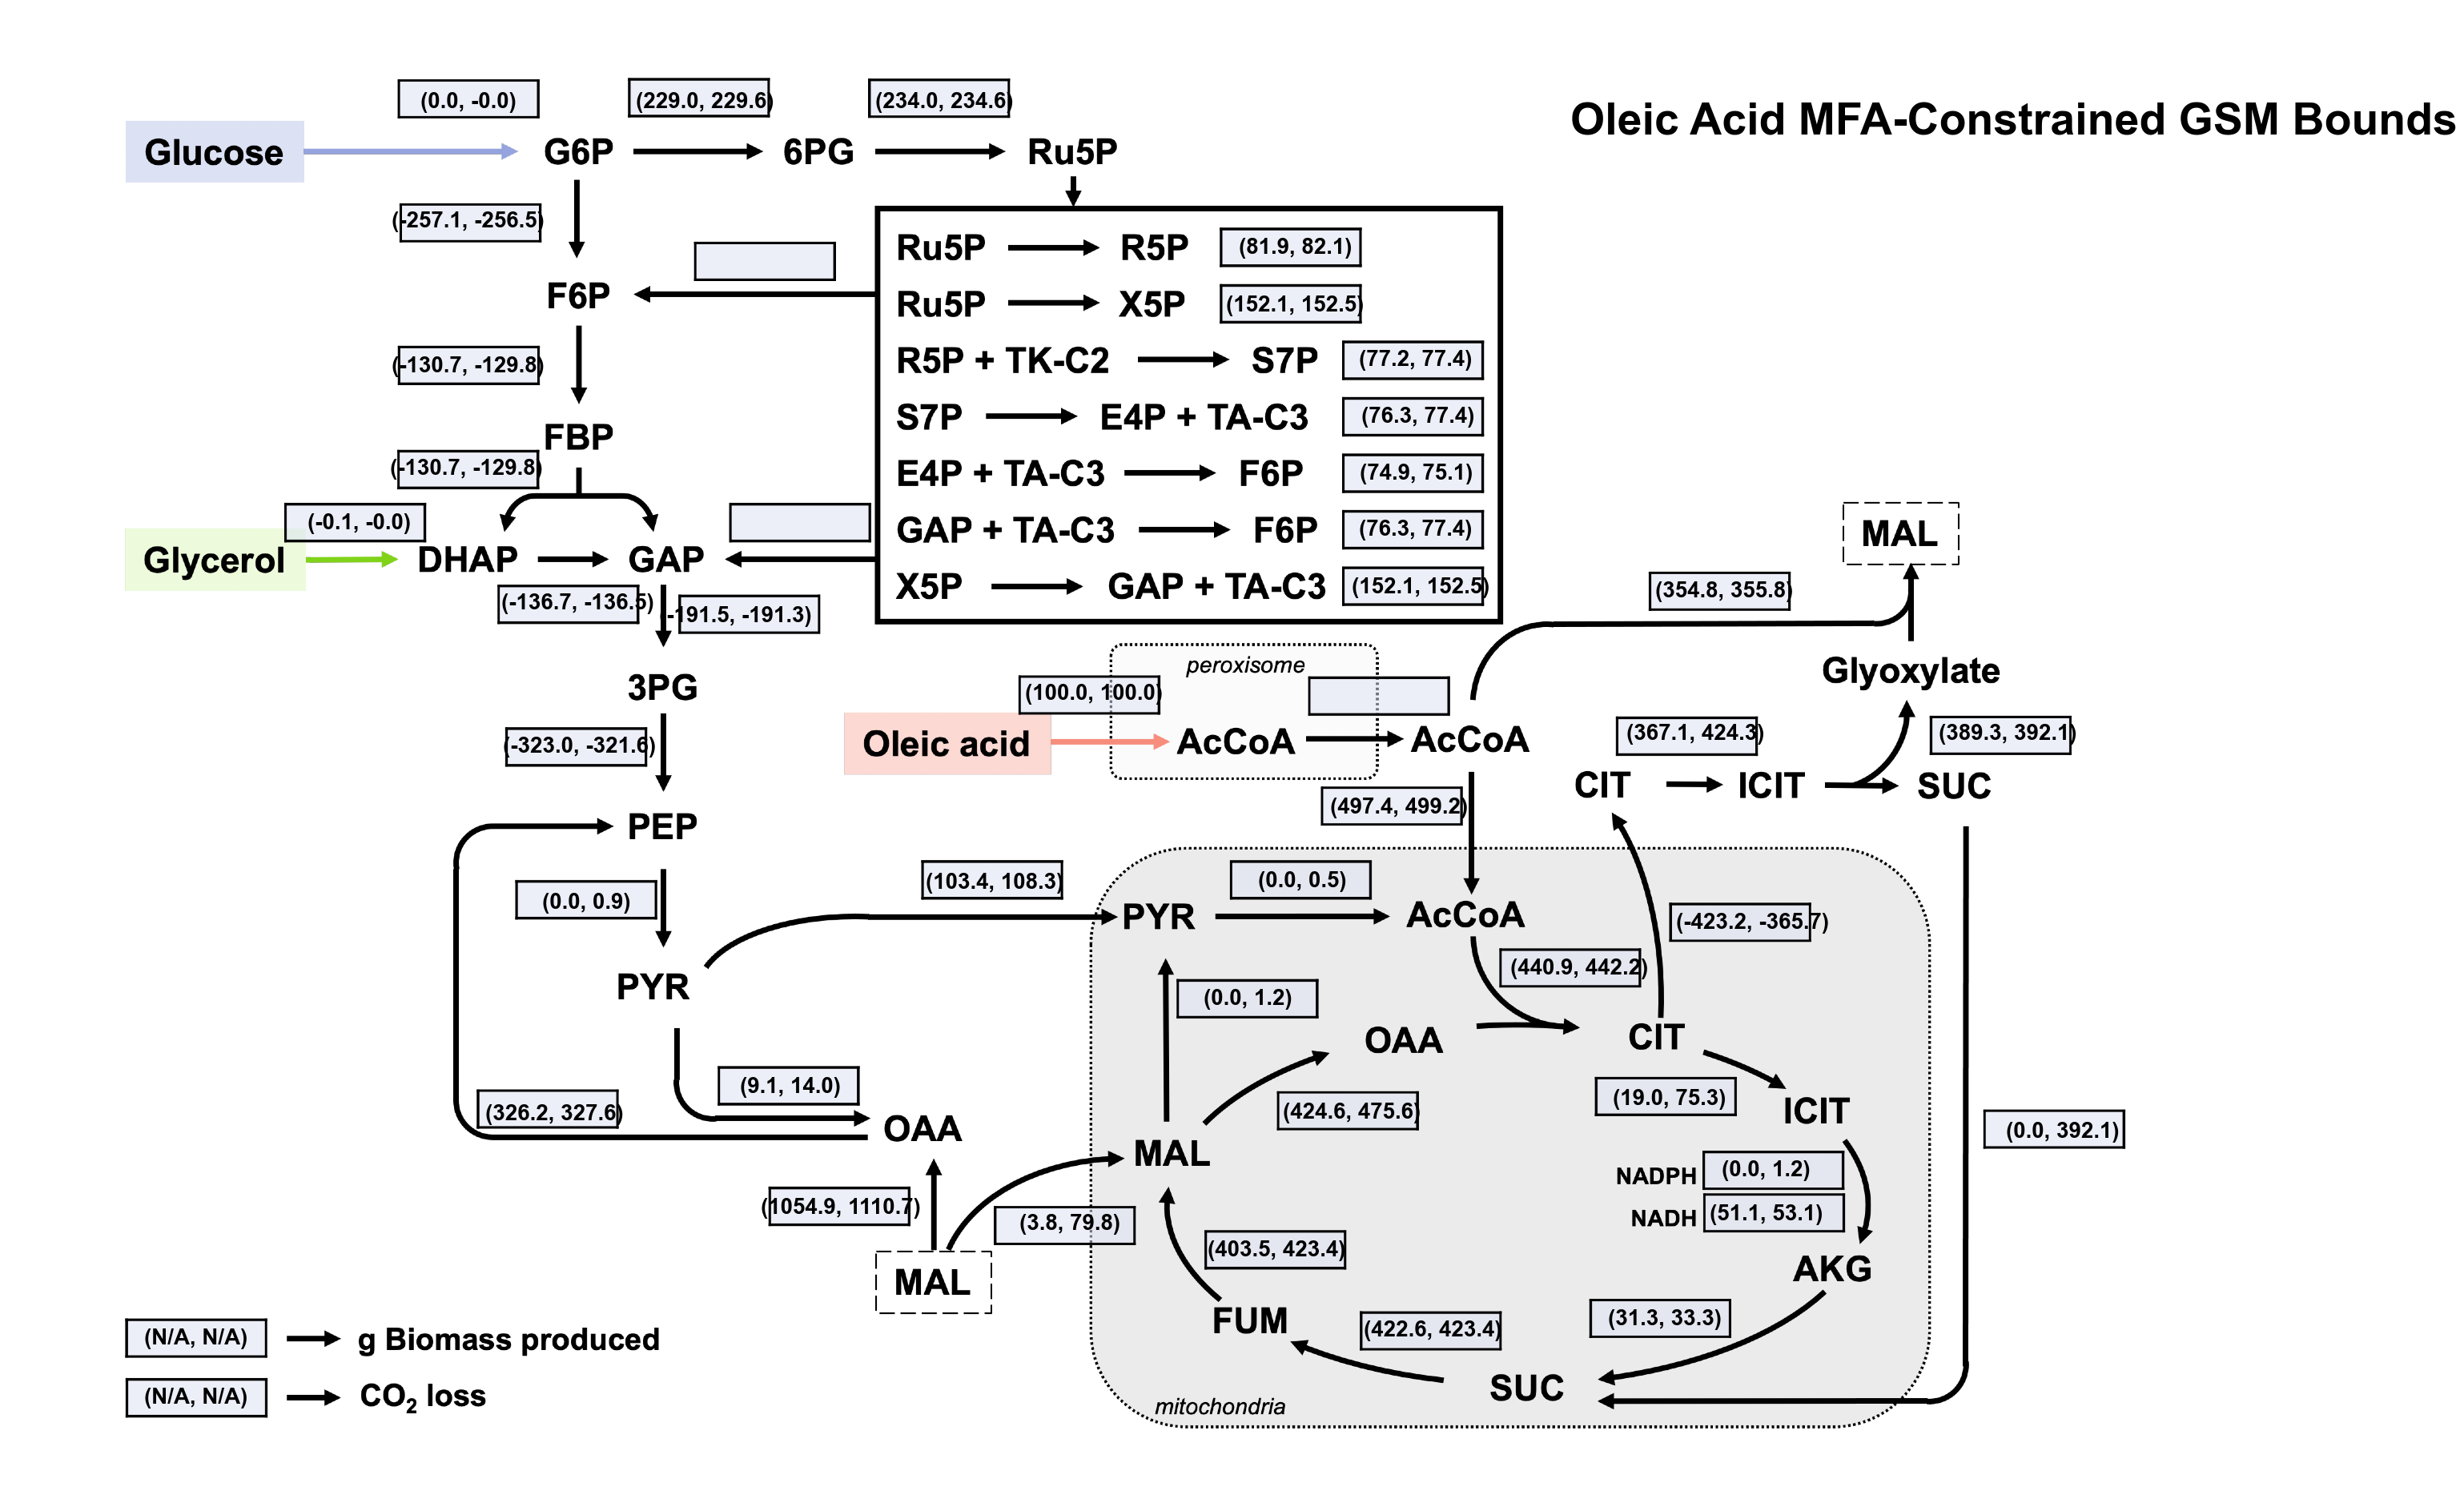

In [16]:
oleic_acid_mfa_map = plot_flux_map(
    flux_df=central_rxn_df, 
    flux_column=['Oleic Acid MFA-Constrained GSM LB', 'Oleic Acid MFA-Constrained GSM UB'],
    title_string='Oleic Acid MFA-Constrained GSM Bounds',
    file_name='../figures/Oleic Acid MFA-Constrained GSM Bounds.png',
)

## Save the GSM bounds that were constrained by the 13C-MFA

In [17]:
# save the central_rxn_df
central_rxn_df.to_csv('../results/central_fluxes/mfa_constrained_gsm_central_bounds.csv')